In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm
import wandb
from dotenv import dotenv_values
import os
import json

In [2]:
envs = ["secret.env"]

for fenv in envs:
    file = os.path.join("env", fenv)
    config = dotenv_values(file)  # load sensitive variables
    print(config.keys())
    for c, v in config.items():
        os.environ[c] = v

odict_keys(['WANDB_API_KEY', 'WANDB_PROJECT'])


In [3]:
wandb_key = os.environ["WANDB_API_KEY"]
wandb.login(key=wandb_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wilber-quito (deepsat). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
class WANDBConfig:

    def __init__(self, job_type: str, config_path: str):
        self.job_type = job_type
        self.config_path = config_path

    def __enter__(self):
        config = {}
        with open(self.config_path) as f:
            config = json.load(f)
            if config["accelerate"]:
                device = "cuda" if torch.cuda.is_available() else "cpu"
                config["device"] = device
            else:
                config["device"] = "cpu"

        wandb.init(job_type=self.job_type, config=config)

    def __exit__(self, exc_type, exc_val, exc_tb):
        wandb.finish()

In [5]:
class ClearCache:
    def __enter__(self):
        torch.cuda.empty_cache()

    def __exit__(self, exc_type, exc_val, exc_tb):
        torch.cuda.empty_cache()

In [61]:
def dataloader():
    # Transforms images to a PyTorch Tensor
    tensor_transform = transforms.ToTensor()

    # Download the MNIST Dataset
    dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=tensor_transform
    )

    generator = torch.Generator().manual_seed(42)
    train_ae_ds, val_ae_ds, train_classifier_ds, val_classifier_ds = (
        torch.utils.data.random_split(
            dataset, [0.6, 0.1, 0.2, 0.1], generator=generator
        )
    )

    # DataLoader is used to load the dataset
    # for training
    train_ae_loader = torch.utils.data.DataLoader(
        dataset=train_ae_ds, batch_size=wandb.config.batch_size, shuffle=True
    )

    val_ae_loader = torch.utils.data.DataLoader(
        dataset=val_ae_ds, batch_size=wandb.config.batch_size, shuffle=False
    )

    train_classifier_loader = torch.utils.data.DataLoader(
        dataset=train_classifier_ds, batch_size=wandb.config.batch_size, shuffle=True
    )

    val_classifier_loader = torch.utils.data.DataLoader(
        dataset=val_classifier_ds, batch_size=wandb.config.batch_size, shuffle=False
    )
    return {
        "ae_train": train_ae_loader,
        "ae_val": val_ae_loader,
        "classifier_train": train_classifier_loader,
        "classifier_val": val_classifier_loader,
    }

In [7]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 10),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
def train_step(model, optimizer, loss_fn, loader):

    model.train()
    batch_loss = 0.0

    for image, _ in loader:

        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28 * 28)
        image = image.to(wandb.config.device)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_fn(reconstructed, image)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss += loss.item() * image.size(0)

    batch_loss = batch_loss / len(loader.dataset)

    return batch_loss


def val_step(model, loss_fn, loader):

    model.eval()
    batch_loss = 0.0

    for image, _ in loader:

        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28 * 28)
        image = image.to(wandb.config.device)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_fn(reconstructed, image)
        batch_loss += loss.item() * image.size(0)

    batch_loss = batch_loss / len(loader.dataset)

    return batch_loss


def train(model, optimizer, loss_fn, train_loader, val_loader):

    model = model.to(wandb.config.device)

    for epoch in tqdm(range(wandb.config.epochs + 1)):
        train_loss = train_step(model, optimizer, loss_fn, train_loader)
        val_loss = val_step(model, loss_fn, val_loader)
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch})

In [ ]:
config_path = "config/autoencoder-ssl.json"
job_type = "autoencoder-ssl"

with WANDBConfig(job_type, config_path) as cf, ClearCache() as cc:
    # Dataloader
    loaders = dataloader()
    train_loader = loaders["ae_train"]
    val_loader = loaders["ae_val"]

    # Model Initialization
    model = AE()

    # Validation using MSE Loss function
    loss_fn = torch.nn.MSELoss()

    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=wandb.config.lr, weight_decay=1e-8
    )
    train(model, optimizer, loss_fn, train_loader, val_loader)

In [10]:
torch.save(model.state_dict(), "pth/autoencoder-ssl.pth")

In [71]:
config_path = "config/autoencoder-ssl.json"
job_type = "autoencoder-ssl"

with WANDBConfig(job_type, config_path) as cf, ClearCache() as cc:

    # Dataloader
    loaders = dataloader()
    train_loader = loaders["ae_train"]
    val_loader = loaders["ae_val"]

    # Loads AutoEncoder weights
    ae = AE()
    state = torch.load(wandb.config.trained_autoencoder_path)
    ae.load_state_dict(state)

In [72]:
import matplotlib.pyplot as plt

images, labels = next(iter(val_loader))
images.shape, labels.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [73]:
ae

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [74]:
ae.eval()

images = images.reshape(-1, 28 * 28)
reconstructed = ae(images).detach().numpy()

In [59]:
len(images)

8

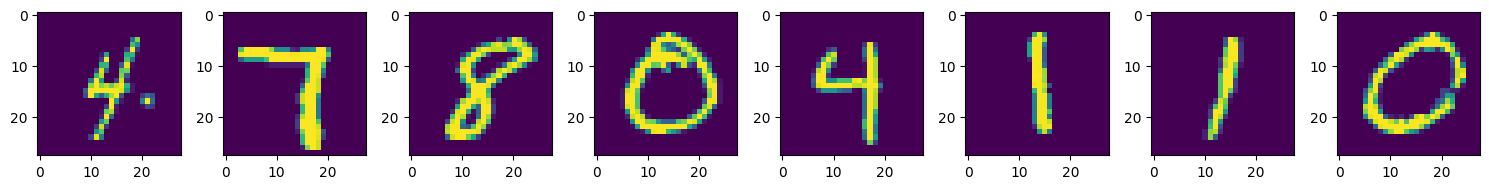

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(15, 3))

for i, ax in enumerate(axes.flat):
    img = images[i].reshape(-1, 28, 28)
    ax.imshow(img[0])

plt.tight_layout()
plt.show()

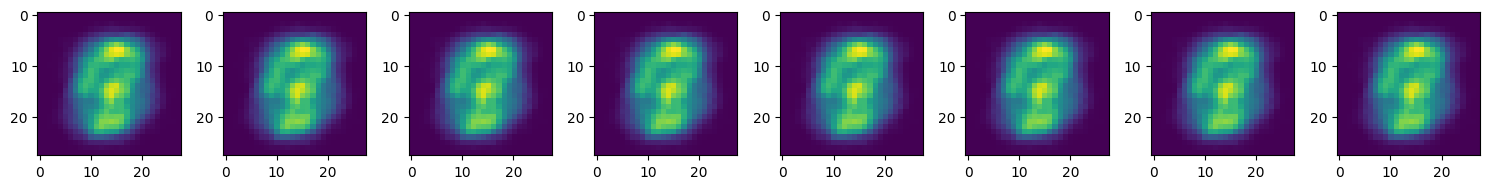

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(15, 3))

for i, ax in enumerate(axes.flat):
    img = reconstructed[i].reshape(-1, 28, 28)
    ax.imshow(img[0])

plt.tight_layout()
plt.show()